<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
values_to_predict = ['x', 'y', 'u', 'v']
IMG_SIZE = 128
BATCH_SIZE = 512

validation_size = 0.1

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_train = df_train.sample(frac=1).reset_index(drop=True)
train_len = df_train.shape[0]
df_validation = df_train[int(train_len*(1-validation_size)):]
df_validation = df_validation.sample(frac=1).reset_index(drop=True)
df_train = df_train[:int(train_len*(1-validation_size))]
df_test = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_test = df_test[['filename','x', 'y', 'u', 'v']]


print("Loading train data ...")
train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    test_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

print("\nLoading validation data ...")
validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    test_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False,
    class_mode = "raw")

print("\nLoading test data ...")
test_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
test_dataset = test_dataset.flow_from_dataframe(
    dataframe = df_test,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    test_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False,
    class_mode = "raw")


Loading train data ...
Found 9233 validated image filenames.

Loading validation data ...
Found 1026 validated image filenames.

Loading test data ...
Found 3101 validated image filenames.


# **Visualizing some images**

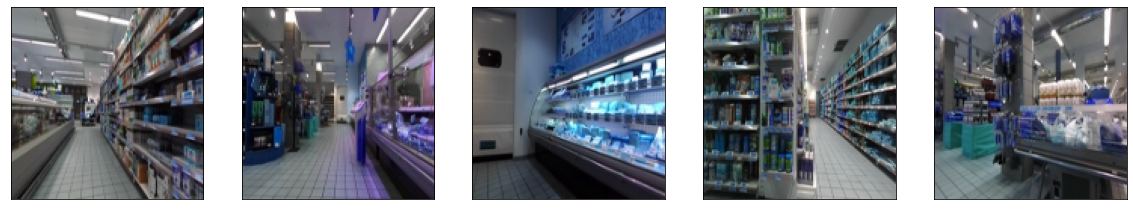

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
files_train = train[:,0]
np.random.shuffle(files_train)


x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


# **Define model's architecture**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model = Sequential([
            Conv2D(16, (3,3), activation = 'relu', padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),
            MaxPooling2D((2, 2), padding='same'),#64x64x16
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x32
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#16x16x64
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#8x8x128
            Flatten(),
            Dense(128, activation='relu'),
            Dense(4)                                       
        ])

model.summary()

optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Train the model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# from keras.models import load_model
# print("Loading model ...")
# model = load_model(MAIN_PATH + "/saved_models/bestmodel-1.4438-15-nov.hdf5")
# print("Model loaded.")

filepath = "/content/drive/My Drive/Colab_Notebooks/CV_Project/"
filepath_models = filepath + "saved_models/weights-improvement-{epoch:02d}-{val_loss:2f}.hdf5"
filepath_csv = filepath + "loss/logs.csv"

checkpoint = ModelCheckpoint(filepath_models, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", min_delta = 0.01, 
                           patience = 5, verbose = 1)
log_csv = CSVLogger(filepath_csv, separator=',', append=True)

callbacks_list = [checkpoint, early_stop, log_csv]

history = model.fit(train_dataset,
                    epochs=100,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    workers = 8)

# **Visualize loss landscape**

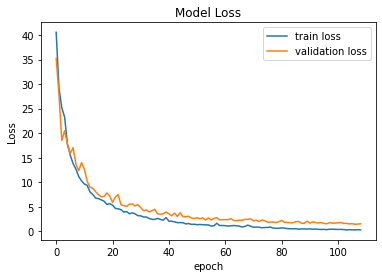

Minimum validation loss reached: 1.4438
Epoch: 106


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

training_log = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/bestmodel-1.4438-15-nov.csv").to_numpy()

loss = training_log[:,1]
val_loss = training_log[:,2]

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.savefig("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/" + 'bestmodel-1.4438-15-nov.png')
plt.show()

print("Minimum validation loss reached: {:.4f}\nEpoch: {:d}".format(np.min(val_loss), np.argmin(val_loss)))

# **Compute predictions**

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np
import math  

# print("Loading model ...")
# model = load_model(MAIN_PATH + "/saved_models/bestmodel-1.4438-15-nov.hdf5")
# print("Model loaded.")

# print("\nStarting predicting ...")
# predicted = model.predict(test_dataset, batch_size = 1024)

predicted = pd.read_csv(MAIN_PATH + "/predictions/predictions_bestmodel-1.4438-15-nov.csv", names=['x', 'y', 'u', 'v']).to_numpy()

def normalize(x):
    return x/(np.sqrt((x**2).sum(1).tolist())).reshape(-1,1)

predicted[:,2:] = normalize(predicted[:,2:])

for i, el in enumerate(predicted[:,2]):
    if(abs(el)>1): 
        predicted[i,2] = np.sign(el)

for i, el in enumerate(predicted[:,3]):
    if(abs(el)>1): 
        predicted[i,3] = np.sign(el)

np.savetxt(MAIN_PATH + "/predictions/predictions_bestmodel-1.4438-15-nov.csv", predicted, delimiter=",")
print("Prediction's done.")

Prediction's done.


# **Compute mean, median errors and accuracy**

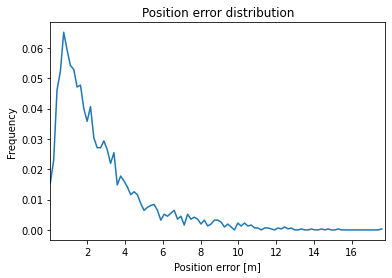

Mean Location Error: 2.6564 m
Median Location Error: 1.9871 m


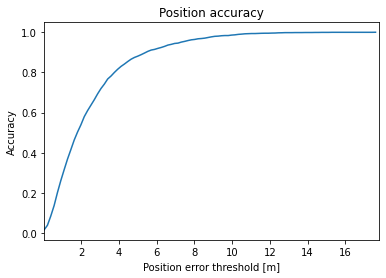

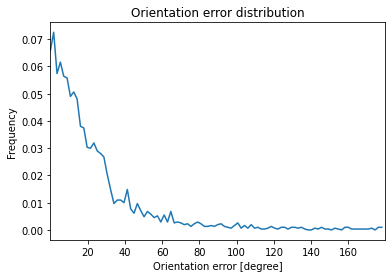

Mean Orientation Error: 23.7064 °
Median Orientation Error: 15.4318 °


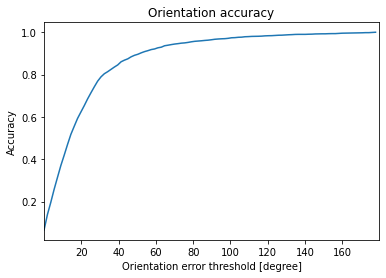

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
predicted = pd.read_csv(MAIN_PATH + "/predictions/predictions_bestmodel-1.4438-15-nov.csv", names=['x', 'y', 'u', 'v']).to_numpy()
df_test = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_test = df_test[['filename','x', 'y', 'u', 'v']]
test = df_test.to_numpy()[:,1:]

def normalize(x):
    return x/(np.sqrt((x**2).sum(1).tolist())).reshape(-1,1)

def accuracy_graph(array):
    accuracy = np.zeros(array.shape)
    
    for i,acc in enumerate(array):
        accuracy[i:] = accuracy[i:] + acc
    
    return accuracy

position_errors = np.sqrt(((predicted[:,:2]-test[:,:2])**2).sum(1).tolist())

#ensure each x vector has norm=1
predicted_orientations = normalize(predicted[:,2:])
test_orientations = normalize(test[:,2:])
cosines = (predicted_orientations*test_orientations).sum(1)

for i, el in enumerate(cosines):
    if(abs(el)>1): 
        cosines[i] = np.sign(el)

orientation_errors = np.degrees(np.arccos(cosines.tolist()))
 
errors = [position_errors.mean(), np.median(position_errors), np.mean(orientation_errors), np.median(orientation_errors)]

loc_hist,  loc_bin = np.histogram(position_errors, bins = 100, density = True)
loc_hist = loc_hist/loc_hist.sum() #normalize
plt.figure()
plt.plot(loc_bin[:-1], loc_hist)
plt.xlim(np.min(loc_bin), np.max(loc_bin))
plt.title('Position error distribution')
plt.ylabel('Frequency')
plt.xlabel('Position error [m]')
plt.show()
print("Mean Location Error: %0.4f m" % (errors[0],))
print("Median Location Error: %0.4f m" % (errors[1],))

plt.figure()
plt.plot(loc_bin[:-1], accuracy_graph(loc_hist))
plt.xlim(np.min(loc_bin), np.max(loc_bin))
plt.title('Position accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Position error threshold [m]')
plt.show()

orient_hist,  orient_bin = np.histogram(orientation_errors, bins = 100, density = True)
orient_hist = orient_hist/orient_hist.sum() #normalize
plt.figure()
plt.plot(orient_bin[:-1], orient_hist)
plt.xlim(np.min(orient_bin), np.max(orient_bin))
plt.title('Orientation error distribution')
plt.ylabel('Frequency')
plt.xlabel('Orientation error [degree]')
plt.show()
print("Mean Orientation Error: %0.4f °" % (errors[2],))
print("Median Orientation Error: %0.4f °" % (errors[3],))

plt.figure()
plt.plot(orient_bin[:-1], accuracy_graph(orient_hist))
plt.xlim(np.min(orient_bin), np.max(orient_bin))
plt.title('Orientation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Orientation error threshold [degree]')
plt.show()

In [ ]:
print(accuracy_graph(loc_hist)[loc>5][0])
print(accuracy_graph(orient_hist)[ori>60][0])

# **Failure cases analysis**

In [ ]:
import pandas as pd
import numpy as np
import math
import cv2

#Useful functions to view the location indicated by the model

def find_img_from_label(query, dataset):
    """
    Input: series of queries
    Output: indexes of nearest images from the dataset

    """
    idx_min = 0
    diff_min = np.sqrt(((query-dataset[0,:])**2).sum())
    label = query #only temporary to initialize label

    for i,row in enumerate(dataset):
        diff = np.sqrt(((query-row)**2).sum())
        if diff<diff_min:
            idx_min = i
            diff_min = diff
            label = row

    return idx_min, diff_min, label

def rotate(query, alpha, sum=True):
    """
    Return query rotated of the angle alpha

    """    
    query_out = query.copy()
    query_out[2:] = query_out[2:]/np.sqrt((query_out[2:]**2).sum())

    # query_out[2] = query_out[2]/10
    # query_out[3] = query_out[3]/10

    if sum:
        theta = math.atan2(query_out[3],query_out[2])
        theta = math.degrees(theta)
        theta = theta + alpha
    else:
        theta = alpha

    theta = math.radians(theta)
    query_out[2] = math.cos(theta)
    query_out[3] = math.sin(theta)

    # query_out[2] = query_out[2]*10
    # query_out[3] = query_out[3]*10

    return query_out

def plot_failure(real_img, real_position, pred_img, wrong_positions, label, test):
    """
    Input:
    real_img: image from test set
    real_position: ground truth of real_img
    pred_img: image with the label nearest to the predicted one
    wrong_position: predicted label
    label: gound truth of pred_img
    test: test set, needed to draw the map of the supermarket
    """
    delta = 1

    plt.figure(figsize=(30, 6))

    ax = plt.subplot(1, 3, 1)
    plt.imshow(real_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title("Input image :\n (x,y) =  [{:.2f}, {:.2f}], angle = {:.2f}°".format(
    #         real_position[0], real_position[1], 
    #         real_position[2], real_position[3],
    #         math.degrees(math.atan2(real_position[3],real_position[2]))))
    ax.set_title("Input image", fontsize=20)


    ax = plt.subplot(1, 3, 2)
    ax.grid()
    plt.imshow(pred_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title("Image nearest the predicted location :\n (x,y) =  [{:.2f}, {:.2f}], angle = {:.2f}°".format(
    #         wrong_positions[0], wrong_positions[1],
    #         math.degrees(math.atan2(wrong_positions[3],wrong_positions[2]))))
    ax.set_title("Image matched", fontsize=20)
    
    ax = plt.subplot(1, 3, 3)
    ax.grid()
    ax.set_title("Map with label of input (green), prediction (red)\nand location of the matched image (magenta)", fontsize=20)
    ax.xlim = (np.min(test[:,0]), np.max(test[:,0]))
    ax.ylim = (np.min(test[:,1]), np.max(test[:,1]))
    plt.plot(test[:,0],test[:,1], linestyle = "--", color = "k")
    plt.arrow(real_position[0], real_position[1], 
              real_position[2], real_position[3],
              width=0.3, ec="k", fc="g")
    plt.arrow(wrong_positions[0], wrong_positions[1], 
              wrong_positions[2], wrong_positions[3],
              width=0.3, ec="k", fc="r")
    plt.arrow(label[0], label[1], 
              label[2], label[3],
              width=0.3, ec="k", fc="m")
    x = np.array([real_position[0], wrong_positions[0], label[0]])
    y = np.array([real_position[1], wrong_positions[1], label[1]])
    plt.plot(x, y, color = "b")
    # plt.show()

    


In [ ]:
MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"

predicted = pd.read_csv(MAIN_PATH + "/predictions/predictions_bestmodel-1.4438-15-nov.csv", names=['x', 'y', 'u', 'v']).to_numpy()
rooms = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room']).to_numpy()[:,5]

test = df_test.to_numpy()[:,1:]
train =  df_train.to_numpy()[:,1:]

######################
# SELECT FAILURES
######################
min = 5
max = 100

for room in range(16):
    idx_err = (position_errors>min)&(position_errors<max)
    # idx_err = (orientation_errors>60)&(orientation_errors<180)
    idx_room = (rooms == room)
    n_failures = (idx_err & idx_room).sum()
    print("Failure cases : {:d}/{:d} ({:.2f}%), room : {:d}, error : {:.2f} m".format(
        n_failures,idx_room.sum(), (n_failures/idx_room.sum())*100,room,min))

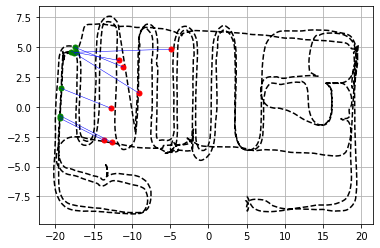

Failure cases : 7/186 (3.76%), room : 15, error : 5.00 m


In [ ]:
######################
# COMPUTE
######################
idx_room = (rooms == 15)
n_failures = (idx_err & idx_room).sum()

wrong_positions = predicted[idx_err & idx_room] #predictions of failure cases
real_position = test[idx_err & idx_room] #ground truth of failure cases

plt.plot(test[:,0],test[:,1], linestyle = "--", color = "k")
plt.plot(real_position[:,0],real_position[:,1], marker = ".", markersize = 10, linestyle = " ", color = "g")
plt.plot(wrong_positions[:,0],wrong_positions[:,1], marker = ".", markersize = 10, linestyle = " ", color = "r")

x = np.vstack((real_position[:,0], wrong_positions[:,0])).transpose()
y = np.vstack((real_position[:,1], wrong_positions[:,1])).transpose()
for i in range(real_position.shape[0]):
    plt.plot(x[i,:], y[i,:], color = "b", linewidth = 0.5)
    
plt.grid()
plt.show()

print("Failure cases : {:d}/{:d} ({:.2f}%), room : {:d}, error : {:.2f} m".format(
        n_failures,idx_room.sum(), (n_failures/idx_room.sum())*100,room,min))

In [ ]:
for room in range(16):
    idx_room = (rooms == room)
    n_failures = (idx_err & idx_room).sum()

    wrong_positions = predicted[idx_err & idx_room] #predictions of failure cases
    real_position = test[idx_err & idx_room] #ground truth of failure cases

    for i in range(n_failures):
        sel_img = i #select one of the failure cases to be analysed
        if sel_img > n_failures: sel_img = n_failures - 1

        real_filename = df_test.to_numpy()[:,0][idx_err & idx_room][sel_img]
        #dalla label predetta a partire dall'input prendo dal train l'immagine con la label che più si avvicina
        query = rotate(wrong_positions[sel_img], 0)
        queries_idx, diff_min, label = find_img_from_label(query, train) #search predicted image in the train set from the predicted label
        pred_filenames = df_train["filename"].to_numpy()[queries_idx]

        real_img = cv2.imread(MAIN_PATH + "/images/" + real_filename)
        real_img = real_img/255
        pred_img = cv2.imread(MAIN_PATH + "/images/" + pred_filenames)
        pred_img = pred_img/255

        plot_failure(real_img, real_position[sel_img], pred_img, query, label, test)
        plt.savefig("/content/drive/MyDrive/Colab_Notebooks/CV_Project/failures/room_"+str(room)+"_"+'err_5m_'+str(i) +'.png', dpi=300)
        plt.close()
        print("Predicted location : (x,y) =  [{:.2f}, {:.2f}], angle = {:.2f}°".format(label[0], label[1], math.degrees(math.atan2(label[3],label[2]))))
        print("Query error : ", diff_min)
        print("Position error : ", position_errors[idx_err & idx_room][sel_img])
        print("Orientation error : ", orientation_errors[idx_err & idx_room][sel_img])